In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

from geopy.distance import great_circle
from shapely.geometry import MultiPoint

from random import sample 

from shapely.geometry import Point
import pyproj
geod = pyproj.Geod(ellps='WGS84')

import seaborn as sns
sns.set_style("whitegrid")

                   
    
import os
import glob
%matplotlib inline

# 1.Radius Tests

The goal of this notebook is to understand how different home and stay radii impact the count and representativeness of the cell phone data. To do this, I will look at home radii of 150 meters and 250 meters, and stay radii of [10,20,30,50] for each.

The logic behind this is: 

- We only need to find the home location to the precision of the census block group's boundaries.
- The average block group area (when cutting off the long tail at around 1,000,000 m^2, is around 165,000m^2. 
- This means, supposing a square (that's an assumption for calc purpose), that each side is around 406 m long. Inscribing a circle inside would result in a circle with radius approx. 200m. 
- Because there is imprecision in the points, we'll use a 50m buffer, and look at 150 m and 250m on either side of the 200m to see what results. 
- For stay points, the radius needs to be much tighter in order to approximate interactions. 


## 1.0 Get Data

### 1.0.1 Read all home locations for each day

Testing this on Jul 2, 2019

In [33]:
rad_test_folders = glob.glob('/Volumes/Elements/Cuebiq/01_Analysis/Radius_test/*')

In [34]:
files_final= glob.glob('/Volumes/Elements/Cuebiq/01_Analysis/Results_150m_10m_ALL/*')
all_datesnow = list(set([x.split('/')[-1].split('_')[-2] for x in files_final]))

In [35]:
k = 599
h_list = []
s_list = []
for each in rad_test_folders:
    sample_files_home =glob.glob(each+'/home_locs_*.csv')
    li_h = []
    for filename in sample_files_home:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_h.append(df)

    h = pd.concat(li_h, axis=0, ignore_index=True)
    h['radius'] = "{}_{}".format(each.split('/')[-1].split('_')[1],each.split('/')[-1].split('_')[2])
    h_list.append(h)

    sample_files_stay = glob.glob(each+'/stays_*.csv')
    li_s = []
    for filename in sample_files_stay:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_s.append(df)

    s = pd.concat(li_s, axis=0, ignore_index=True)
    s['radius'] = "{}_{}".format(each.split('/')[-1].split('_')[1],each.split('/')[-1].split('_')[2])
    s_list.append(s)
home = pd.concat(h_list)
home = home[home.radius.isin(['150m_10m','250m_10m'])]
stay = pd.concat(s_list)
stay = stay[stay.radius.isin(['150m_10m','150m_20m','150m_30m','150m_50m'])]

Join all Dfs

In [36]:
home = pd.concat(h_list)
home = home[home.radius.isin(['150m_10m','250m_10m'])]
stay = pd.concat(s_list)
stay = stay[stay.radius.isin(['150m_10m','150m_20m','150m_30m','150m_50m'])]

Convert to geo_df

In [38]:
home_geo = gpd.GeoDataFrame(home,geometry = gpd.points_from_xy(home.home_lng,home.home_lat,crs="EPSG:4326"))
stay_geo = gpd.GeoDataFrame(stay,geometry = gpd.points_from_xy(stay.stay_lng,stay.stay_lat,crs="EPSG:4326"))

## 1.1 Compare counts

In [39]:
for each in home.radius.unique():
    print("For {}, home is {} and stay is {}".format(each,home[home.radius==each].shape[0],stay[stay.radius==each].shape[0]))

for each in stay.radius.unique():
    print("For {}, home is {} and stay is {}".format(each,home[home.radius==each].shape[0],stay[stay.radius==each].shape[0]))



For 150m_10m, home is 6737 and stay is 122500
For 250m_10m, home is 6943 and stay is 0
For 150m_10m, home is 6737 and stay is 122500
For 150m_20m, home is 0 and stay is 220905
For 150m_30m, home is 0 and stay is 303060
For 150m_50m, home is 0 and stay is 566092


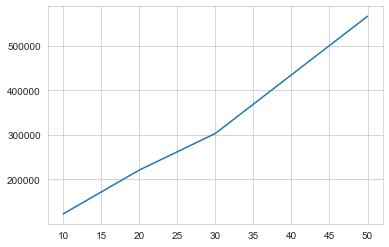

In [40]:
plt.plot([10,20,30,50],[122500,220905,303060,566092])
plt.show()

## 1.2 Get a sense of the general radius distribution 

In [29]:
test = pd.read_csv('/Volumes/Elements/Cuebiq/01_Analysis/part-00000-1245d2d8-7236-447f-81ef-5f02ddf12568-c000.csv',sep="\t",header=None).rename(columns={0:'datetime',1:'uid',2:'dunno',3:'lat',4:'lng',5:'acc',6:'ele'})

In [30]:
test['acc'].describe()

count    6.800300e+04
mean     8.693093e+01
std      6.077172e+03
min      0.000000e+00
25%      5.000000e+00
50%      1.200000e+01
75%      6.500000e+01
max      1.576811e+06
Name: acc, dtype: float64

In [31]:
test['acc'].quantile(.90)

65.0

In [60]:
thres_rad = 500
test[test.acc>thres_rad].shape[0]/test.shape[0]

0.028954604943899533

In [61]:
test1 = test[test.acc>thres_rad]

# 2. Velocity Test

The goal of this notebook is to understand the distribution of mobility speeds and what portion of the data is higher velocity. 


## 2.1 Percentage of data removed due to velocity threshold

In [64]:
def sort_uid_dt(x):
    x = x.sort_values(['uid','datetime'])
    return x
def get_distance1(x1,y1,x2,y2):
    angle1,angle2,distance = geod.inv(x1,y1,x2,y2)
    return distance
vdistance = np.vectorize(get_distance1)

def get_distance(x):
    '''
    Returns the distance between two consecutive points after sorting by datetime
    '''

    return vdistance(x['lng'],x['lat'],x['lng'].shift(1),x['lat'].shift(1))

In [65]:
## This is a pretty good upper bound, determined
day1= test[test.acc<=500]
day1['datetime']=pd.to_datetime(day1.datetime,unit='s') - pd.Timedelta(hours=6)

day2 =day1.sort_values(['uid','datetime'])

/Users/wenfeixu/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
day3 = day2.assign(lat_prev =day2['lat'].shift(),
			  lng_prev =day2['lng'].shift())

In [67]:
day4 = day3.assign(dist=day3.apply(lambda x: vdistance(x['lng'],x['lat'],x['lng_prev'],x['lat_prev']),axis=1).fillna(-99))
day4 = day4.fillna(-99)

/Users/wenfeixu/anaconda3/envs/gds/lib/python3.7/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [106]:
day5 = day4.assign(time_diff =day4['datetime'].diff().dt.total_seconds())
day5.loc[57494,'dist']= 0
day6 = day5.assign(vel = day5.apply(lambda x: x['dist']/(x['time_diff']/(60)),axis=1))
day6 = day6.replace(np.inf,-99)
day6 = day6.replace(np.nan,-99)


/Users/wenfeixu/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/wenfeixu/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
vel_thres = 400 ## This seem to be a good upper bound for removing all the vehicular traffic (based on exporting the data and a visual inspection)
day7 = day6[(day6.vel <vel_thres)]
day7= gpd.GeoDataFrame(day7,geometry=[Point(xy) for xy in zip(day7.lng,day7.lat)])


In [111]:
day7['vel'].describe()

count    16615.000000
mean       100.257505
std        120.897986
min          0.000000
25%          4.218820
50%         37.278620
75%        179.201030
max        399.955176
Name: vel, dtype: float64

In [112]:
day7.shape[0]/test.shape[0]

0.2443274561416408

## 2.2 Percentage of data removed due to transit mode

In [74]:
streets_buffer = gpd.read_file('Data/Shapefiles/tl_2013_17031_roads/buffers_30ft_rad_dissolve/buffers_30ft_rad_dissolve.shp')

In [115]:
pts_on_road = gpd.sjoin(day7,streets_buffer)

/Users/wenfeixu/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [116]:
(day7.shape[0]-pts_on_road.shape[0])/test.shape[0]

0.38210078967104394

In [118]:
day7[(day7.index.isin(pts_on_road)==False)&(day7.vel>=0)]['vel'].describe()

count    16615.000000
mean       100.257505
std        120.897986
min          0.000000
25%          4.218820
50%         37.278620
75%        179.201030
max        399.955176
Name: vel, dtype: float64

In [119]:
day8 =day7[(day7.index.isin(pts_on_road)==False)]

## 3. Home location descriptive statistics


In [162]:
home_all = pd.read_pickle('home_loc_MOREINFO.pickle')

In [142]:
li = []
for each in glob.glob('/Volumes/Elements/Cuebiq/01_Analysis/Results_150m_10m_ALL/home_locs*.csv'):
    df = pd.read_csv(each, index_col=None, header=0)
    li.append(df)
    date = each.split('/')[-1].split("_")[-1].split('.')[0]
    df['date'] = date
home = pd.concat(li, axis=0, ignore_index=True)


In [150]:
home.groupby('uid').count()['home_lng'].describe()

count    129997.000000
mean          5.669115
std          10.165365
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         117.000000
Name: home_lng, dtype: float64

## 3.1 Percentage of data removed due to land use 
This calculation was done in the remote server, but according to my notes there are around 7k removals. 

In [144]:
7000/(home.shape[0]+7000)

0.009409006839003827

# 4. Stay location descriptive statistics

In [164]:
stays_all = pd.read_pickle('stays2.pickle')

In [160]:
li = []
for each in glob.glob('/Volumes/Elements/Cuebiq/01_Analysis/Results_150m_10m_ALL/stay*.csv'):
    df = pd.read_csv(each, index_col=None, header=0)
    li.append(df)
    date = each.split('/')[-1].split("_")[-1].split('.')[0]
    df['date'] = date
stays = pd.concat(li, axis=0, ignore_index=True)

stays = pd.concat(li, axis=0, ignore_index=True)
stays = stays.sort_values(['uid','trip_label','datetime'])
stays.reset_index(drop=True,inplace=True)



In [169]:
stays.groupby(['uid','date','trip_label','stay_label']).count()['lat'].describe()

count    2.456050e+06
mean     4.652094e+00
std      6.573381e+00
min      3.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      2.518000e+03
Name: lat, dtype: float64

Stays with no home locations are removed

In [163]:
stays1 = stays[stays.uid.isin(home_all.uid)]
stays1['datetime']=pd.to_datetime(stays1['datetime'])
stays1['day']=pd.to_datetime(stays1['datetime']).dt.day

/Users/wenfeixu/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/wenfeixu/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
stays1.groupby(['uid','date','trip_label','stay_label']).count()['lat'].describe()

count    1.644955e+06
mean     4.692748e+00
std      7.060652e+00
min      3.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      2.518000e+03
Name: lat, dtype: float64

In [166]:
stays_all.shape

(1644955, 8)